# Residual Circulation at 100 hPa

Cleaning needed before publicationpublicationbpublicationbpublicationbpublicationb!!!!!

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import importlib
import string

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )

from analysis import Omega, day

In [5]:
read_from_original_data = False

if read_from_original_data:
    dset = reader.read_wifiaus_combination( file_type = 'echam', average_type = 'tzmean')
    forcing = reader.read_wifiaus_combination( file_type = 'forcing', average_type = 'tzmean' )

    d = xr.merge([dset, forcing])


    ## Prepare Vars 

    p = d['hyam']  + d['hybm'] * d['aps']

    p = p.rename({'nhym':'lev'})
    psel = p.sel(mode = 'fire0.0', ensemble = 'nudged').mean(('time', 'lat'))

    d.lev.where(psel> 700e2).load().min()
    #d.lev.where(psel> 700e2).load().max()


    theta = d['tpot']
    lts = theta.sel(lev = 47) - theta.sel(lev=39)

    d['LTS'] = lts


    ## Averaging

    def averaged_dset( d, diving_lat = 20 ):

        # lat is stored backwards
        sh_range = [-diving_lat, -90]
        tropics_range = [diving_lat, -diving_lat]
        nh_range = [90, diving_lat]

        drange = []
        for latrange in [sh_range, tropics_range, nh_range]:
            ds = d.sel( lat = slice(*latrange) )
            d_weighted_ave = analysis.weighted_mean( ds )
            d_weighted_ave = d_weighted_ave.expand_dims('latrange')
            d_weighted_ave['latrange'] = [str(latrange),]

            drange +=[ d_weighted_ave, ]

        drange = xr.concat( drange, dim = 'latrange')

        return drange

    dave = d.drop_vars(['time_bnds', 'hyai', 'hybi', 'hyam', 'hybm'])

    dave = averaged_dset( dave )

else:
    
    dave_file = '~/data/wifi-aus/statistics/wifiaus-combined-vars-latrange.nc'
    dave = xr.open_dataset(dave_file).squeeze()

In [6]:
dave.load()

<xarray.Dataset>
Dimensions:         (time: 3, lev: 47, mode: 5, ensemble: 37, latrange: 3)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-16T14:52:30 ... 2020-03-16T...
    lon             float64 0.0
  * lev             (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
  * mode            (mode) object 'fire0.0' 'fire1.0' ... 'fire3.0' 'fire5.0'
  * ensemble        (ensemble) object 'nudged' 'ens1.000000' ... 'ens1.000070'
  * latrange        (latrange) object '[-20, -90]' '[20, -20]' '[90, 20]'
Data variables: (12/132)
    q               (latrange, mode, ensemble, time, lev) float64 2.964e-06 ....
    xl              (latrange, mode, ensemble, time, lev) float64 0.0 ... 7.4...
    xi              (latrange, mode, ensemble, time, lev) float64 1.841e-34 ....
    sh_vdiff        (latrange, mode, ensemble, time) float64 17.61 ... 24.97
    ev_vdiff        (latrange, mode, ensemble, time) float64 2.378e-05 ... 2....
    ch_concloud     (latrange, mode, ensemble, time) float64 35.82 ... 37.46
    ...              ...
    FSW_TOTAL_SUR   (latrange, mode, ensemble, time) float64 -2.038 ... -6.455
    FLW_CLEAR_TOP   (latrange, mode, ensemble, time) float64 0.1715 ... 1.433
    FLW_TOTAL_TOP   (latrange, mode, ensemble, time) float64 0.09981 ... 0.8872
    FLW_CLEAR_SUR   (latrange, mode, ensemble, time) float64 0.5477 ... 2.815
    FLW_TOTAL_SUR   (latrange, mode, ensemble, time) float64 0.2382 ... 1.618
    LTS             (latrange, mode, ensemble, time) float64 -14.16 ... -14.24

In [7]:
d = xr.open_dataset('/home/b/b380352/data/wifi-aus/statistics/all-echam-by-latitude.nc')
d = d.drop_vars([ 'hyai', 'hybi', 'hyam', 'hybm'])


In [8]:
circ = xr.open_dataset('~/data/wifi-aus/statistics/circulation-vars-by-latitude-and-pressure.nc')
mom = xr.open_dataset('~/data/wifi-aus/statistics/momentum-vars-by-latitude-and-pressure.nc')


In [9]:
time = d.time
#del time['plev']

In [10]:
phi = np.deg2rad( d.lat )
f = 2*Omega*np.sin(phi)
mom['EPF_scaled'] = mom['minus_EPF'] / f
mom['dPhi_dy_scaled'] = mom['dPhi_dy'] / f


In [11]:
rad_heating = circ['dtdt_rheat_lw'] + circ['dtdt_rheat_sw']
sw_heating = circ['dtdt_rheat_sw']

net_heating = rad_heating+ circ['dtdt_cucall'] + circ['dtdt_cloud']

theta = circ['tpot']
scaling = theta / circ['t']

# calculate stability
Gamma = theta.differentiate('plev')

circ['rad_heating_scaled'] = scaling / Gamma * rad_heating / day
circ['net_heating_scaled'] = scaling / Gamma * net_heating / day
circ['sw_heating_scaled'] = scaling / Gamma * sw_heating / day

circ['Gamma'] = Gamma


In [12]:
circ['omega']

<xarray.DataArray 'omega' (time: 3, mode: 5, ensemble: 37, plev: 50, lat: 96)>
[2664000 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 2020-01-31 2020-02-29 2020-03-31
    lon       float64 ...
  * lat       (lat) float64 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev      (plev) float64 1.0 4.0 11.0 23.0 ... 9.787e+04 9.918e+04 1e+05
  * mode      (mode) object 'fire0.0' 'fire1.0' 'fire2.0' 'fire3.0' 'fire5.0'
  * ensemble  (ensemble) object 'nudged' 'ens1.000000' ... 'ens1.000070'
Attributes:
    long_name:      vertical velocity
    units:          Pa/s
    code:           135
    table:          128
    CDI_grid_type:  gaussian
    cell_methods:   time: mean
    institution:    MPIMET

In [13]:
rad_heating = circ['dtdt_rheat_lw'] + circ['dtdt_rheat_sw']
sw_heating = circ['dtdt_rheat_sw']

net_heating = rad_heating + circ['dtdt_cucall'] + circ['dtdt_cloud']

theta = circ['tpot']
scaling = theta / circ['t']


circ['diabatic_heating'] = circ['diabatic_heating'] * day

# calculate stability
Gamma = 1.
day1 = 1.
scaling = 1.

circ['rad_heating_scaled'] = scaling / Gamma * rad_heating / day1
circ['net_heating_scaled'] = scaling / Gamma * net_heating / day1
circ['sw_heating_scaled'] = scaling / Gamma * sw_heating / day1
circ['reduced_heating'] = circ['net_heating_scaled'] + circ['diabatic_heating']


In [14]:
dlist = []
for i in range(3):
    
    if i == 0:
        dtheta = theta.isel( time = 0, )
    else:
        dtheta = theta.isel( time = i, ) - theta.isel( time = i-1, )

    
    dtheta = dtheta.expand_dims('time')
    dtheta['time'] = [i,]

    dlist +=[ dtheta, ]

dtheta = xr.concat( dlist, dim = 'time')

dtheta['time'] = circ.time

circ['dtheta'] = dtheta / 30 / day1 / Gamma

In [15]:
rangelabels = ['SH', 'S Trop', 'N Trop', 'NH']
dividing_lat = [-20, 10, 30 ]

In [16]:
rangelabels = ['SH', 'Tropics', 'NH']
dividing_lat = [-20, 20 ]

In [17]:
c = analysis.averaged_dset( circ, diving_lat= dividing_lat )
m = analysis.averaged_dset( mom, diving_lat= dividing_lat )
dave = analysis.averaged_dset( d, diving_lat= dividing_lat )

c = c.assign_coords({'time':time})
m = m.assign_coords({'time':time})

In [18]:
time

<xarray.DataArray 'time' (time: 3)>
array(['2020-01-16T14:52:30.000000000', '2020-02-15T14:52:30.000000000',
       '2020-03-16T14:52:30.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-16T14:52:30 ... 2020-03-16T14:52:30
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T

In [19]:
c.data_vars

Data variables:
    t                   (latrange, time, mode, ensemble, plev) float64 187.1 ...
    u                   (latrange, time, mode, ensemble, plev) float64 -12.08...
    v                   (latrange, time, mode, ensemble, plev) float64 8.256 ...
    aps                 (latrange, time, mode, ensemble) float64 9.837e+04 .....
    omega               (latrange, time, mode, ensemble, plev) float64 -1.899...
    tpot                (latrange, time, mode, ensemble, plev) float64 5.024e...
    uu                  (latrange, time, mode, ensemble, plev) float64 210.3 ...
    uv                  (latrange, time, mode, ensemble, plev) float64 -108.4...
    uomega              (latrange, time, mode, ensemble, plev) float64 1.672e...
    utheta              (latrange, time, mode, ensemble, plev) float64 -6.08e...
    vv                  (latrange, time, mode, ensemble, plev) float64 100.4 ...
    vomega              (latrange, time, mode, ensemble, plev) float64 -1.596...
    vtheta  

### More Vars 

In [20]:
dave['F_sw_surf_noaer'] = dave['srads'] - dave['FSW_TOTAL_SUR']
dave['F_sw_toa_noaer']  = dave['srad0'] - dave['FSW_TOTAL_TOP']
dave['F_lw_toa_noaer']  = dave['trad0'] - dave['FLW_TOTAL_TOP']

dave['F_sw_surf_noaer_clear'] = dave['srafs'] - dave['FSW_CLEAR_SUR']
dave['F_sw_toa_noaer_clear']  = dave['sraf0'] - dave['FSW_CLEAR_TOP']
dave['F_lw_toa_noaer_clear']  = dave['traf0'] - dave['FLW_CLEAR_TOP']

dave['cre_sw'] = dave['F_sw_toa_noaer'] - dave['F_sw_toa_noaer_clear']
dave['cre_lw'] = dave['F_lw_toa_noaer'] - dave['F_lw_toa_noaer_clear']


dave['cre_sw_dirty'] = dave['srad0'] - dave['sraf0']
dave['cre_lw_dirty'] = dave['trad0'] - dave['traf0']

dave['cloud_on_forc_sw'] = dave['FSW_TOTAL_TOP'] - dave['FSW_CLEAR_TOP']
dave['cloud_on_forc_lw'] = dave['FLW_TOTAL_TOP'] - dave['FLW_CLEAR_TOP']


In [21]:
L = 2e6
dave['LP'] = L * ( dave['aprc'] + dave['aprl'] )
dave['LPl'] = L * ( dave['aprl'] )

dave['F_atm,low'] = dave['sradl'] - dave['srads']
dave['F_atm,middle'] = dave['srad0'] - dave['sradl']

dave['lwcc'] = -( dave['trafl'] - dave['trafs'] )
dave['lwc'] = -( dave['tradl'] - dave['trads'] )

dave['Q'] = -( dave['sradl'] - dave['srads'] ) + dave['lwc'] - dave['ahfs']



In [22]:
alpha = -3500  # muller and O Gorman (2011)

dave['om500'] = c['omega'].sel( plev = 500e2, method = 'nearest')
dave['oms500'] = c['omega_star'].sel( plev = 500e2, method = 'nearest')

dave['aom500'] = alpha * c['omega'].sel( plev = 500e2, method = 'nearest')
dave['aoms500'] = alpha * c['omega_star'].sel( plev = 500e2, method = 'nearest')

dave['LTS'] = dave['tpot'].isel( lev = -1) - c['tpot'].sel( plev = 700e2, method = 'nearest')

In [23]:
# dry static energy

In [24]:
mask = c.plev > 300e2

R = 287
c_p = 1004
tm =  c['t'].where(mask).dropna('plev')
s = (c_p + R )*tm.integrate('plev')

seconds_since = (time - np.datetime64('2020-01-01T00') ) * 1e-9
seconds_since.data =  seconds_since.data.astype(np.float)

dave['s'] = s / seconds_since

/tmp/ipykernel_3687519/2615320697.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seconds_since.data =  seconds_since.data.astype(np.float)


In [25]:
day = 24 * 3600.
dave['dh500'] = day *  c['diabatic_heating'].sel( plev = 500e2, method = 'nearest')

In [26]:
dave = dave.squeeze()
dave = dave.transpose('latrange', 'time', 'mode', 'ensemble', 'lev',)

In [27]:
# momentum variables

plevel = [200e2, 100e2, 50e2]
names = ['mom_bal200', 'mom_bal100', 'mom_bal50']

for i in range(3):
    kws = dict(plev = plevel[i], method = 'nearest')
    name = names[i]

    dave[f'x{name}_fvs'] = day *  m['fvs'].sel( **kws )
    dave[f'x{name}_EPF'] = - day *  m['minus_EPF'].sel( **kws)
    dave[f'x{name}_residuum'] = day *  (m['fvs'] - m['minus_EPF']) .sel( **kws)
    dave[f'x{name}_dudt'] = day *  (m['u'] / seconds_since ) .sel( **kws)
    
    dave[f'y{name}_fu'] = day *  m['minus_fu'].sel( **kws )
    dave[f'y{name}_dPhidy'] = - day *  m['dPhi_dy'].sel( **kws)
    dave[f'y{name}_dPhidy_scaled'] = -  m['dPhi_dy_scaled'].sel( **kws)
    
    dave[f'y{name}_residuum'] = day *  (m['minus_fu'] - m['dPhi_dy']) .sel( **kws)
    dave[f'y{name}_dvdt'] = day *  (m['v'] / seconds_since ) .sel( **kws)
    dave[f'y{name}_dvsdt'] = day *  (c['v_star'] / seconds_since ) .sel( **kws)
    



In [28]:
# momentum variables
plevel = [200e2, 100e2, 50e2]
names = ['200', '100', '50']

for i in range(3):
    kws = dict(plev = plevel[i], method = 'nearest')
    name = names[i]

    dave[f'vs_{name}'] =  (c['v_star'] ) .sel( **kws)
    dave[f'u_{name}'] =  (c['u'] ) .sel( **kws)


    dave[f'EPF_scaled{name}'] = m['EPF_scaled'].sel(**kws)

    dave[f'oms_{name}'] = c['omega_star'].sel(**kws)
    dave[f'rhs_{name}'] = c['rad_heating_scaled'].sel(**kws)
    dave[f'nhs_{name}'] = c['net_heating_scaled'].sel(**kws)
    dave[f'swh_{name}'] = c['sw_heating_scaled'].sel(**kws)
    dave[f'dia_{name}'] = c['diabatic_heating'].sel(**kws)
    dave[f'redheat_{name}'] = c['reduced_heating'].sel(**kws)
    
    

    dave[f'theta_{name}'] = c['tpot'].sel(**kws)
    dave[f'dtheta_{name}'] = c['dtheta'].sel(**kws)
    dave[f'theta_scaled{name}_G'] = ( c['tpot'] /  c['Gamma']).sel(**kws) / seconds_since 
    dave[f'theta_scaled{name}'] = c['tpot'].sel(**kws) / seconds_since 
    
    dave[f'Gamma{name}'] = ( c['Gamma']).sel(**kws)
    
    

## Prepare Robust Fit 

In [29]:
# plot line of best for multiple robust regression algorithms
from sklearn.linear_model import RANSACRegressor
import scipy.stats

# plot the dataset and the model's line of best fit
def get_best_fit(X, y, model = RANSACRegressor()):
    # fit the model on all data
    model.fit(X, y)
    
    xaxis = np.linspace(X.min(), X.max(), 10)
    # calculate outputs for grid across the domain
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))

    return xaxis, yaxis


## Plotting 

In [30]:

def plot_vars_against_eachother(vname1, vname2, print_correlation = False, add_nudged = True, reference = 'None',
                                add_ensemble = True, gray_arrow = False, axs = None, iabc = 0,
                                rangelabels = [r'Southern Hemisphere', 'Tropics', r'Northern Hemisphere',],
                                sharex = True, sharey = True,
                                scale1 = 1, scale2 = 1.):
    
    colors = ['C0', 'C1', 'C2', 'C3']  # for modes
    symbols = ['o', 's', 'v'] # for months
    
    
 #   dens = analysis.ens_stat( dave ).squeeze()
    dens = analysis.stats_and_nudged( dave ).squeeze()

    modes = list( dens.mode.data )
    months = list( dave.time.data )
    latranges = list( dave.latrange.data )
    xmin, xmax = 1e3, -1e3
    ymin, ymax = 1e3, -1e3

    
    # reference vs. anomaly
    vartype1 = 'mean'
    vartype2 = 'mean'
    vartype1_nudged = 'nudged'
    vartype2_nudged = 'nudged'
    
    varconf_scale1 = 1.
    varconf_scale2 = 1.
    
    if reference == 'var1' or reference == 'both':
        vartype1 = 'reference'
        vartype1_nudged = 'nudged-reference'
        
        varconf_scale1 = 0.5   # because two random vars contribute to difference
    
    if reference == 'var2' or reference == 'both':
        vartype2 = 'reference'
        vartype2_nudged = 'nudged-reference'

        varconf_scale2 = 0.5   # because two random vars contribute to difference
    
    abc = string.ascii_lowercase
        
    if axs is None:
        fig, axs = plt.subplots(ncols = len(latranges), figsize = (22,5))
                            
    for j, month in enumerate(months):
        for i, mode in enumerate(modes):
            
            kws = dict(mode = mode, time = month)
            d1ens = scale1 * dens[vname1].sel(**kws)
            d2ens = scale2 * dens[vname2].sel(**kws)
            
            
            
            for k, latrange in enumerate(latranges): 

                    
                
                d1mean = d1ens.sel(stats = vartype1, latrange = latrange)
                d2mean = d2ens.sel(stats = vartype2, latrange = latrange)

                d1conf = varconf_scale1 * d1ens.sel(stats = 'confidence', latrange = latrange)
                d2conf = varconf_scale2 * d2ens.sel(stats = 'confidence', latrange = latrange)

                if add_ensemble:
                    axs[k].errorbar( d1mean, d2mean, xerr = d1conf, yerr = d2conf,
                                 ecolor = 'lightgray', markersize = 14, mec = 'w',  mew = 2, 
                                 color = colors[i], marker = symbols[j], lw = 1.,
                                 zorder = 10 - i)
                
                if add_nudged:
                    d1n = d1ens.sel(stats = vartype1_nudged, latrange = latrange)
                    d2n = d2ens.sel(stats = vartype2_nudged, latrange = latrange)
                    
                    axs[k].errorbar( d1n, d2n, xerr = 0, yerr = 0,
                                 markersize = 10, mec = colors[i], mew = 2,
                                 color = 'w', marker = symbols[j], 
                                 lw = 1., zorder = 3)
                    
            
                axs[k].set_xlabel( vname1 )
                axs[k].set_ylabel( vname2 )
                axs[k].set_title( '(%s) %s' % (abc[k +iabc], rangelabels[k]), fontweight = 'normal' )
                
                xmi, xma = axs[k].get_xlim()
                ymi, yma = axs[k].get_ylim()
                
                if xmi < xmin:
                    xmin = xmi
                if xma > xmax:
                    xmax = xma
                if ymi < ymin:
                    ymin = ymi
                if yma > ymax:
                    ymax = yma
    
    for a in axs:
        if sharex:
            a.set_xlim(xmin, xmax)
        if sharey:
            a.set_ylim(ymin, ymax)
        
    if print_correlation:
        for k, latrange in enumerate(latranges): 
            
            d1mean = dens[vname1].sel(stats = vartype1, latrange = latrange).data.flatten()
            d2mean = dens[vname2].sel(stats = vartype2, latrange = latrange).data.flatten()

            x = d1mean
            X = x.reshape(-1,1)
            y = d2mean

            cc_rank = scipy.stats.spearmanr(x, y)[0]
            cc =  np.corrcoef(x,y)[0,1]
            p = np.polyfit(x,y,1)
            
            
            xfit, yfit = get_best_fit( X, y )
            slope = ( yfit[-1] - yfit[0] )/ (xfit[-1] - xfit[0])
            axs[k].plot(xfit, yfit, color = 'gold', lw = 6, alpha = 0.5, zorder = 2) 

            yfit = np.polyval(p, xfit)
            axs[k].plot(xfit, yfit, color = 'darkgreen', lw = 6, alpha = 0.5, zorder = 0) 

            print(rangelabels[k])
            print('==================')
            print('correlation: %.2f %.2f' % (cc, cc_rank))
            print('slopes:',  p[0], slope )
            print()

    if gray_arrow:

        for k, latrange in enumerate(latranges): 
        
            if add_ensemble:
                # arrow base
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-01')
                xB = dens[vname1].sel(stats = vartype1, **kws).data.flatten()[0]
                yB = dens[vname2].sel(stats = vartype2, **kws).data.flatten()[0]

                # arrow head
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-03')
                xH = dens[vname1].sel(stats = vartype1, **kws).data.flatten()[0]
                yH = dens[vname2].sel(stats = vartype2, **kws).data.flatten()[0]
            else:
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-01')
                xB = dens[vname1].sel(stats = vartype1_nudged, **kws).data.flatten()[0]
                yB = dens[vname2].sel(stats = vartype2_nudged, **kws).data.flatten()[0]

                # arrow head
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-03')
                xH = dens[vname1].sel(stats = vartype1_nudged, **kws).data.flatten()[0]
                yH = dens[vname2].sel(stats = vartype2_nudged, **kws).data.flatten()[0]

            dx = xH - xB
            dy = yH - yB
            dist = np.sqrt(dy**2 + dx**2)
            
            print( xB, yB, dx, dy, dist)
            axs[k].arrow(x=xB, y=yB, dx = dx, dy = dy,  width=1e-3, color = 'gray', 
                         zorder = 0, length_includes_head = True) 

In [31]:
def plot_oneone():
    fig = plt.gcf()

    for a in fig.axes:
        xmin, xmax = a.get_xlim()
        ymin, ymax = a.get_ylim()

        vmin = np.minimum( xmin, ymin )
        vmax = np.minimum( xmax, ymax )

        a.plot( [vmin,vmax], [vmin, vmax], color = 'k', alpha = 0.1, lw = 5)

In [32]:
def nicify( xlabel = None, ylabel = None, title = None, ylab_size = 22, axs = None ):
    
    if axs is None:
        fig = plt.gcf()
        axs = fig.axes
        
    if title is not None:
        plt.figtext(0.5, 0.93, title, fontsize = 22, fontweight = 'bold', ha = 'center' )
    for a in axs:
        
        if xlabel is not None:
            a.set_xlabel( xlabel )
        
        if ylabel is not None:
            a.set_ylabel( ylabel, labelpad = 20, fontsize = ylab_size )
            
    plt.subplots_adjust( wspace = 0.6, hspace = 0.6, top = 0.8, left = 0.2, right = 0.8 )
    

## Plots for Paper

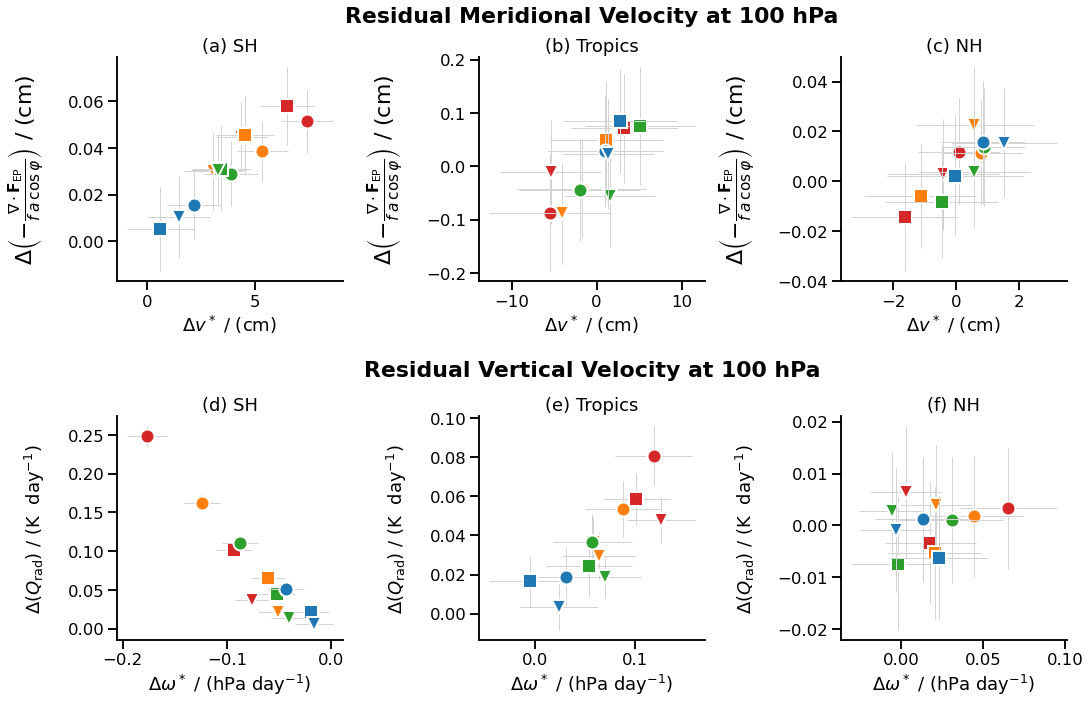

In [33]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,12))


#####################################################
title = 'Residual Meridional Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'vs_100', 'EPF_scaled100',  rangelabels = rangelabels, sharex = False, sharey = False, add_nudged = False, scale1 = 1e2, axs = axs[0,:])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta v^*$ / (cm)', ylabel = r'$\Delta \left(-\frac{\nabla\cdot\mathbf{F}_\mathrm{EP}}{f\;a\,\cos\varphi} \right)$ / (cm)', axs = axs[0,:] )
plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )


#####################################################
title = 'Residual Vertical Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'oms_100', 'rhs_100',  rangelabels = rangelabels,sharex = False, sharey = False, add_nudged = False, scale1 = 1e-2 * day, axs = axs[1,:], iabc = 3 )
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta\omega^*$ / (hPa day${}^{-1}$)', ylabel = r'$\Delta\left(Q_\mathrm{rad}\right)$ / (K  day${}^{-1}$)',  ylab_size = 18, axs = axs[1,:] )
plt.figtext(0.5, 0.43, title, fontsize = 22, fontweight = 'bold', ha = 'center' )

plt.savefig('../pics/res-circ-at-100hPa', dpi = 600)